<a href="https://colab.research.google.com/github/breakwa/Model-Learning/blob/main/TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCN开山之作
## 1.要解决的问题
为了处理原始音频生成所需要的长期时间依赖性，我们开发了基于扩展因果卷积的新架构，该架构展示了非常大的感受域。
## 2.数学模型
在本文中，我们引入了一种新的生成模型，直接操作原始音频波形。
一个波形$\mathbf{x}=\left\{x_{1}, \ldots, x_{T}\right\}$分解为条件概率的乘积
$$
p(\mathbf{x})=\prod_{t=1}^{T} p\left(x_{t} \mid x_{1}, \ldots, x_{t-1}\right)
$$
因此，每个音频样本xt取决于所有之前的时间步骤的样本。

**条件概率分布**由一叠卷积层进行建模。网络中没有池化层，模型的输出与输入具有相同的时间维度。该模型通过softmax层输出下一个值xt上的分类分布，并对其进行优化，以最大限度地提高数据的对数似然。

## 3.扩张卷积（因果卷积 扩张卷积）
![image.png](https://s2.loli.net/2022/05/27/8Ljv31bofA2pdVz.png)
WaveNet的主要组成是**因果卷积**。通过使用因果卷积，我们确保模型不会违反我们对数据建模的顺序:预测$p\left(x_{t+1} \mid x_{1}, \ldots, x_{t}\right)$由模型在时间步$t$发出，不能依赖于未来的任何时间步$x_{t+1}, x_{t+2}, \ldots, x_{T}$，如图2所示。

在训练时，所有时间步的条件预测可以并行进行，因为地面真值x的所有时间步都是已知的。当与模型一起生成时，预测是连续的:每个样本被预测后，它被反馈到网络中，预测下一个样本。

由于具有因果卷积的模型没有循环连接，它们通常比rnn训练更快，特别是当应用于非常长的序列时。因果卷积的一个问题是，它们需要很多层，或大型过滤器来增加接收野。例如，在图2中，接收场只有5 (= #layers + filter length - 1)。在本文中，我们使用**扩张卷积**来增加接收场的数量级，而不会大大增加计算成本。

![image.png](https://s2.loli.net/2022/05/27/V4DCMfQ3e5WodUG.png)

扩展卷积(也称为trous’，或带孔的卷积)是通过以一定的步长跳过输入值，在大于其长度的区域上应用滤波器的卷积。它相当于与一个更大的滤波器的卷积，通过0来扩大原始滤波器，但显著地更有效。
与正常的卷积相比，膨胀的卷积可以有效地使网络在一个更大的尺度上运行。这类似于池化或跨步卷积，但这里的输出大小与输入相同。作为一种特殊情况，扩张卷积（扩张为
1）等价于标准卷积。

图3描绘了扩张1、2、4和8的扩张因果卷积。扩张卷积以前被用于各种环境中，例如信号处理(Holschneider等，1989;Dutilleux, 1989)。

堆叠扩张卷积使网络具有非常大的接收域，虽然只有几层。堆叠扩张卷积同时保持整个网络的输入分辨率和计算效率。在本文中，每一层膨胀翻倍，直至极限，然后重复，如：
1, 2, 4, . . . , 512, 1, 2, 4, . . . , 512, 1, 2, 4, . . . , 512.
这种配置背后的动机有两方面。首先，指数级增加膨胀因子导致感受野随深度指数级增长(Yu & Koltun, 2016)**例如**每个1、2、4……， 512块的接受域大小为1024，可以看作是1×1024卷积的**更有效**和鉴别(非线性)的对应。其次，堆叠这些块进一步增加了模型容量和接收野的大小。

## 4.softmax分布
条件分布建模的一种方法是p (xt |x1，…， xt−1)对单个音频样本将使用混合模型，如混合密度网络(Bishop, 1994)或条件高斯尺度混合(MCGSM) (Theis & Bethge, 2015)。：然而，van den Oord等人(2016a)表明，softmax分布往往工作得更好，其中一个原因是，分类分布更灵活，更容易为任意分布建模，因为它不需要对它们的形状进行假设。

因为原始音频通常以16位整数值序列的形式存储(每个时间步一个整数值)，softmax层需要每个时间步输出65,536个概率来建模所有可能的值。
为了使这一过程更容易处理，我们首先对数据应用一个**u-law压缩变换(ITU-T, 1988)**，然后将其量化为256个可能的值:$$
f\left(x_{t}\right)=\operatorname{sign}\left(x_{t}\right) \frac{\ln \left(1+\mu\left|x_{t}\right|\right)}{\ln (1+\mu)}
$$
其中−1 < xt < 1， μ = 255;这种非线性量化产生了比简单的线性量化方案更好的重构。特别是对于语音，我们发现量化后的重构信号听起来与原始信号非常相似。
## 5.门控激活单元
我们使用与Gated PixelCNN相同的门控激活单元(van den Oord等人，2016b):$$
\mathbf{z}=\tanh \left(W_{f, k} * \mathbf{x}\right) \odot \sigma\left(W_{g, k} * \mathbf{x}\right)
$$*表示一个卷积算子，$\odot$表示与元素相关的乘法运算符,σ(·)为sigmoid函数，k为层指数，f和g分别表示滤波器和门，W是可学习的卷积滤波器。在我们最初的实验中，我们观察到这种非线性比修正的线性激活函数(ReLU)(Nair & Hinton, 2010)用于建模音频信号的效果要好得多。
## 6.残差和跳跃连接
![image.png](https://s2.loli.net/2022/05/27/8gwaiWlJYE3DbST.png)
残差(He et al.， 2015)和参数化跳过连接在整个网络中使用，以加快收敛速度，并使训练更深入的模型。在图4中，我们展示了我们模型的一个残差块，它在网络中被多次叠加。
## 7.条件wavenets
给定一个额外的输入h, WaveNets可以模拟给定这个输入的音频的条件分布p (x | h)。式(1)现在变成$$
p(\mathbf{x} \mid \mathbf{h})=\prod_{t=1}^{T} p\left(x_{t} \mid x_{1}, \ldots, x_{t-1}, \mathbf{h}\right)

$$**通过调节模型的其他输入变量，我们可以引导WaveNet的生成产生所需特征的音频**。例如，在多扬声器设置中，我们可以通过将扬声器标识作为额外输入输入模型来选择扬声器。类似地，对于TTS，我们需要提供关于文本的信息作为额外的输入。

我们以两种不同的方式对模型进行其他输入条件化:全局条件化和局部条件化。全局条件反射的特征是单个潜在表征h，它影响所有时间步的输出分布，例如TTS模型中嵌入的说话者。式(2)的激活函数变为:$$
\mathbf{z}=\tanh \left(W_{f, k} * \mathbf{x}+V_{f, k}^{T} \mathbf{h}\right) \odot \sigma\left(W_{g, k} * \mathbf{x}+V_{g, k}^{T} \mathbf{h}\right)
$$其中V *，k是一个可学习的线性投影，向量V
T
*，kh在时间维度上传播。

对于局部条件反射，我们有第二个时间序列ht，可能具有比音频信号更低的采样频率，例如TTS模型中的语言特征。我们首先使用转置卷积网络(学习上采样)对该时间序列进行变换，将其映射到一个新的时间序列y = f(h)，其分辨率与音频信号相同，然后在激活单元中使用该时间序列如下:$$
\mathbf{z}=\tanh \left(W_{f, k} * \mathbf{x}+V_{f, k} * \mathbf{y}\right) \odot \sigma\left(W_{g, k} * \mathbf{x}+V_{g, k} * \mathbf{y}\right)
$$
其中Vf k * y现在是1×1卷积。作为转置卷积网络的替代方案，也可以使用Vf、k * h并跨时间重复这些值。我们在实验中发现，这种方法的效果稍差。

# 从CNN 到因果CNN 到扩张CNN 到TCN
## 全连接与一维CNN
全连接 （每条线表示$wx+b$）⭕表示activation（.），
eg：sigmoid（w_1 * x + w_2 * x+w_3 * x + w_4 * x+w_1 * x + w_5 * x）
![image.png](https://s2.loli.net/2022/05/27/Mv4cOL2KtVzhgYJ.png)
标准CNN
（稀疏连接：有第二层每个节点与第一层互相连接简化为 第二层每个节点仅仅与第一层的kernel_size个点相互连接）
参数共享（每三个连接的权重不变，叫kernel，size=3）

![Imgur](https://i.imgur.com/Ew5VZR3.png)
这种结果是不适用于时序问题的。

## 因果CNN
![Imgur](https://i.imgur.com/72cuDVc.png)
如何实现因果CNN？padding!
![Imgur](https://i.imgur.com/RMGaKoI.png)
相比于传统padding在两边补零，因果的padding在一侧补零。

### 引入感受野(想实现第K步仅仅与前K-1步有关，K为输入序列长度)
![Imgur](https://i.imgur.com/25bxINT.png)
新的问题：如何解决长序列依赖？ 更多的滤波器×  or 扩张卷积√

## 扩张卷积
![Imgur](https://i.imgur.com/U0cvGnP.png)
(间隔d步采样)
![Imgur](https://i.imgur.com/Wbku8Jk.png)
这样，每个时刻的输出包含K_size感受野内所有信息。
![Imgur](https://i.imgur.com/0m6NMmD.png)
感受野与TCN层数、kernel_size 的关系

### 暂时解决了梯度消失问题
![Imgur](https://i.imgur.com/7zfsW63.png)

# resnet解决梯度消失
问题引入：
![Imgur](https://i.imgur.com/EnfNy80.png)
![Imgur](https://i.imgur.com/Y1Ae7Je.png)

具体思路见桌面resnet pdf

# 0.模型概览

In [ ]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies  # without the dependencies if you already have TF/Numpy.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.2 MB/s 
     |████████████████████████████████| 462 kB 71.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.
batch_size, time_steps, input_dim = None, 10, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    print(pos_indices)
    x_train = np.zeros(shape=(size, time_steps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0  # we introduce the target in the first timestep of the sequence.
    y_train[pos_indices, 0] = 1.0  # the task is to see if the TCN can go back in time to find it.
    return x_train, y_train


tcn_layer = TCN(input_shape=(time_steps, input_dim))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
    tcn_layer,
    Dense(1)
])

m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=False)

x, y = get_x_y()
m.fit(x, y, epochs=3, validation_split=0.2)

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
[393 468 647 201 434 366   1 158 117 742 705 631 882 167 698 909 269 706
 453 754 111 644 276 781 725   7 131 277 308 957 591 348 651 703  75  13
 349 203 249 684 182 141   3 207 510 874 193 708 847   8 541 701 132 330
 124 586 743 235 815 447 129 593 363 820 788 782 836 350 144  28 243 404
 219 405 733 400 819 656 540 716 439 136 215 259 547 652 613  37 910  72
 880  85 430 507  24 273 891 829 104 792 356 237 925 251 121 755 234 383
  48 566 926 226 491 987 659 939 653  34 862 123  18 658 180 993 412 571
 818 945 796 721 931 616 724 980 425 695 394  73 825 376 714 326 877 289
 463 640 678  45 712 343  76 666  67 321 261 340 867  23 477 971 466 458
 127 912 106 856 140 492 681 313 699  11  50 660  62 126 600 932 876 183
  99 549  38  91  33 739 233 726 869 415  64 950 190 663  86 711 760 181
   0 257 668 389 446 323 469 373 630 977 413 683 906 635 424 500 108 387
 930 990 674 620 750 622 

In [ ]:
x_train, y_train = get_x_y(size=5)
x_train, y_train

[4 3]


(array([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]]),
 array([[0.],
        [0.],
        [0.],
        [1.],
        [1.]]))

# 1.模型输入输出
## 1.1 输入 
3D tensor with shape (batch_size, timesteps, input_dim).
**三维张量（批处理大小，时间步，输入维度）**
## 1.2 输出 
*  if return_sequences=True: 3D tensor with shape (batch_size, timesteps, nb_filters).**若return_sequences=True：输出为（批处理大小，时间步，输出的维度）**
*  if return_sequences=False: 2D tensor with shape (batch_size, nb_filters).**若return_sequences=False：输出为（批处理大小，输出的维度）**

nb_filter: Number of convolution kernels to use (dimensionality of the output). 


# 例程

In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 370 kB 7.7 MB/s 
     |████████████████████████████████| 1.4 MB 50.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 793 kB 50.1 MB/s 
     |████████████████████████████████| 584 kB 57.0 MB/s 
     |████████████████████████████████| 9.8 MB 39.5 MB/s 
     |████████████████████████████████| 172 kB 58.3 MB/s 
     |████████████████████████████████| 11.2 MB 43.0 MB/s 
     |████████████████████████████████| 381 kB 62.4 MB/s 
     |████████████████████████████████| 930 kB 51.4 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 66.5 MB/s 
     |████████████████████████████████| 409 kB 45.3 MB/s 
     |████████████████████████████████|

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.8.0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/school_dataset/' #注意kaggle文件夹包含json文件
 
os.chdir('/content/drive/MyDrive/school_dataset/') #切换到kaggle文件夹
 
# !kaggle competitions download -c h-and-m-personalized-fashion-recommendations#下载数据集即可
# !unzip h-and-m-personalized-fashion-recommendations.zip

#加载别的数据集：在右侧三个点 open in new tab ，而后 copy url 放入colab，例如：
#!kaggle datasets download -d xhlulu/cpc-codes --unzip
#如果加载别的比赛的数据集，则用以下方法：
#!kaggle kernels output gauravbrills/folds-dump-the-two-paths-fix 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d nicholasjhana/energy-consumption-generation-prices-and-weather  --unzip

  0% 0.00/3.81M [00:00<?, ?B/s]
100% 3.81M/3.81M [00:00<00:00, 58.8MB/s]


In [ ]:
%matplotlib inline

In [ ]:
!python -m pip uninstall matplotlib
!ypip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 9.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

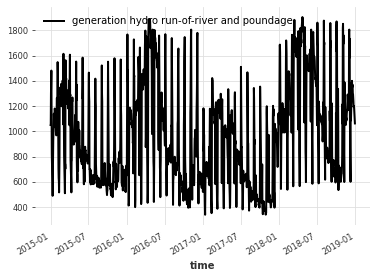

In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
import pandas as pd

df = pd.read_csv('energy_dataset.csv', delimiter=",")
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time']= df.time.dt.tz_localize(None)

df_day_avg = df.groupby(df['time'].astype(str).str.split(" ").str[0]).mean().reset_index()

value_filler = MissingValuesFiller()
series = value_filler.transform(TimeSeries.from_dataframe(df_day_avg, 'time', ['generation hydro run-of-river and poundage']))

series.plot()

In [ ]:
series = series.add_datetime_attribute('day', one_hot=True)

In [ ]:
from darts.dataprocessing.transformers import Scaler

train, val = series.split_after(pd.Timestamp('20170901'))

scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [ ]:
from darts.models import TCNModel

model = TCNModel(
    # input_size=train.width,
    n_epochs=20, 
    # input_length=365,
    # output_length=7, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=7,
    num_filters=4,
    input_chunk_length=365,
    output_chunk_length=7,
   
)

model.fit(series=train_transformed,
    # training_series=train_transformed,
    # target_series=train_transformed,
    # val_training_series=val_transformed,
    # val_target_series=val_transformed, 
    # verbose=True
)

[2022-05-27 08:20:55,868] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 605 samples.
[2022-05-27 08:20:55,868] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 605 samples.
2022-05-27 08:20:55 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 605 samples.
[2022-05-27 08:20:56,030] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-05-27 08:20:56,030] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
2022-05-27 08:20:56 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 5
[2022-05-27 08:20:56,084] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-27 08:20:56,084] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-27 08:20:56 darts.models.forecasting.torch_forecasting_model INFO: Time ser

Training: 0it [00:00, ?it/s]

In [ ]:
pred_series = model.backtest(
    series_transformed,
    # target_series=series_transformed,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    # retrain=False,
    # verbose=True,
    # use_full_output_length=True
)

NameError: ignored